# Installation Setup

In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell
from fredapi import Fred
fred = Fred(api_key = 'b0363f9c9d853b92b27e06c4727bc2ea')
import pandas_datareader.data as web

%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (20,10)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [56]:
import pickle
from multiprocessing import Pool 
import random
import json
import sys
import torch
import gym

import StockPortfolioEnv
import utils
import TD3_BC

import pytz
import itertools
from datetime import datetime as dt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config
from finrl import config_tickers
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [57]:
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
idx = pd.IndexSlice
import warnings
warnings.filterwarnings('ignore')

# Environment configuration
> A gym-style portfolio allocation environment for agents to interact. It is handy to compare the performances.

In [58]:
train_data = pd.read_csv('data/train_data.csv', index_col=0)
trade_data = pd.read_csv('data/trade_data.csv', index_col=0)

In [59]:
train_data

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,fake_macd,fake_rsi_30,fake_cci_30,fake_dx_30,moribvol,equal
0,2007-01-03,40.630,41.830,39.810,40.560,3873900,ADSK,2,0.000,42.034,39.856,100.000,66.667,100.000,40.560,40.560,-1.495,188.432,-24.018,9.889,0.136,0.091
0,2007-01-03,20.080,20.400,19.350,19.520,28350300,AMD,2,0.000,20.037,19.273,100.000,-66.667,100.000,19.520,19.520,1.164,258.488,-12.112,23.279,0.061,0.091
0,2007-01-03,27.460,27.980,27.330,19.536,64226000,CSCO,2,0.000,20.520,19.066,100.000,66.667,100.000,19.536,19.536,-3.028,234.352,96.051,10.989,0.015,0.091
0,2007-01-03,30.170,30.290,28.200,28.500,487000,FSLR,2,0.000,28.979,28.271,100.000,-66.667,100.000,28.500,28.500,-6.141,241.432,-19.203,17.003,0.152,0.091
0,2007-01-03,30.680,31.060,29.100,26.496,4734600,INTU,2,0.000,27.201,26.159,100.000,-66.667,100.000,26.496,26.496,2.663,-20.901,144.368,21.552,0.121,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,2017-12-29,85.630,86.050,85.500,80.353,18717400,MSFT,4,0.755,82.580,76.658,60.144,74.372,15.450,79.209,77.226,7.504,181.526,-70.879,21.943,0.136,0.091
2768,2017-12-29,47.530,47.880,47.280,43.361,9750000,ORCL,4,-0.469,46.547,42.377,42.781,-104.196,16.192,44.585,44.987,3.777,76.235,89.062,22.491,0.015,0.091
2768,2017-12-29,64.360,64.650,64.000,55.318,6631800,QCOM,4,0.254,56.595,55.253,56.700,-86.758,5.702,56.536,52.515,3.266,-136.879,239.818,12.959,0.045,0.091
2768,2017-12-29,104.580,105.080,104.420,90.749,2813300,TXN,4,1.784,93.422,81.992,68.523,122.502,47.232,86.948,84.777,-0.428,79.702,-142.771,34.583,0.121,0.091


In [60]:
# Environment arguments 
stock_dimension = len(train_data.tic.unique())
state_space = stock_dimension
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
fake_tech_indicator_list = ['fake_macd', 'fake_rsi_30', 'fake_cci_30', 'fake_dx_30']
feature_dimension = len(tech_indicator_list)

print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
print(f"Feature Dimension: {feature_dimension}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-1
}

e_train_gym = StockPortfolioEnv.StockPortfolioEnv(df = train_data, **env_kwargs)
e_trade_gym = StockPortfolioEnv.StockPortfolioEnv(df = trade_data, **env_kwargs)

Stock Dimension: 11, State Space: 11
Feature Dimension: 4


In [61]:
# Train
retail_train = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train_data["moribvol"])
true_portfolio_train = e_train_gym.asset_memory
true_actions_train = e_train_gym.actions_memory

# Trade
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=trade_data["moribvol"])
true_portfolio_trade = e_trade_gym.asset_memory
true_actions_trade = e_trade_gym.actions_memory

begin_total_asset:1000000
end_total_asset:4904419.075973194
Sharpe:  0.6730985319353747
begin_total_asset:1000000
end_total_asset:3226196.7258413997
Sharpe:  1.1754037646522397


# Modelling
> Use a two-stage scheme (supervised learning & reinforcement learning), in analogy to AlphaGo and ChatGPT. The first stage learns from human trader logs, while the second stage leverages reinforcement learning to achieve super-human performance.

In [62]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [63]:
# helper functions
def softmax(x):
    """Compute softmax values for each row of x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

def plot_portfolio(y1, y2):
    plt.plot(y1, label='model')
    plt.plot(y2, label='Ground Truth')
    plt.scatter(len(y1)-1, y1[-1], color='blue', label='Model last value: {}'.format(y1[-1]))
    plt.scatter(len(y2)-1, y2[-1], color='red', label='Ground Truth last value: {}'.format(y2[-1]))

    plt.legend()
    plt.ylabel('Portfolio Value')
    plt.xlabel('timesteps')
    plt.show()
    
def plot_mse(y1, y2):
    plt.plot(np.mean((y1 - y2.values.reshape(-1, stock_dimension)), axis=1)**2)
    plt.ylabel('MSE')
    plt.xlabel('timesteps')
    plt.show()
    
def ols_return(y1, y2):
    olsres = sm.OLS(pd.Series(y1).pct_change(), sm.add_constant(pd.Series(y2).pct_change()), missing="drop").fit()
    print(olsres.summary())
    
def ols_action(a1, a2):
    olsres = sm.OLS(a1.values, sm.add_constant(a2.reshape(-1))).fit()
    print(olsres.summary())
    
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [64]:
X = train_data[tech_indicator_list]
Y = train_data["moribvol"]

X_trade = trade_data[tech_indicator_list]
Y_trade = trade_data["moribvol"]

X_fake_train = train_data[fake_tech_indicator_list]
X_fake_trade = trade_data[fake_tech_indicator_list]

## Regression

In [65]:
olsres = sm.OLS(Y.values.reshape(-1), sm.add_constant(X.values.reshape(-1, feature_dimension))).fit()

# train
reg_fit = olsres.predict(sm.add_constant(X.values.reshape(-1, feature_dimension))).reshape(-1, stock_dimension)
reg_fit = softmax(reg_fit)

# trade
reg_trade = olsres.predict(sm.add_constant(X_trade.values.reshape(-1, feature_dimension))).reshape(-1, stock_dimension)
reg_trade = softmax(reg_trade)

begin_total_asset:1000000
end_total_asset:3842940.794783565
Sharpe:  0.6112156959205777


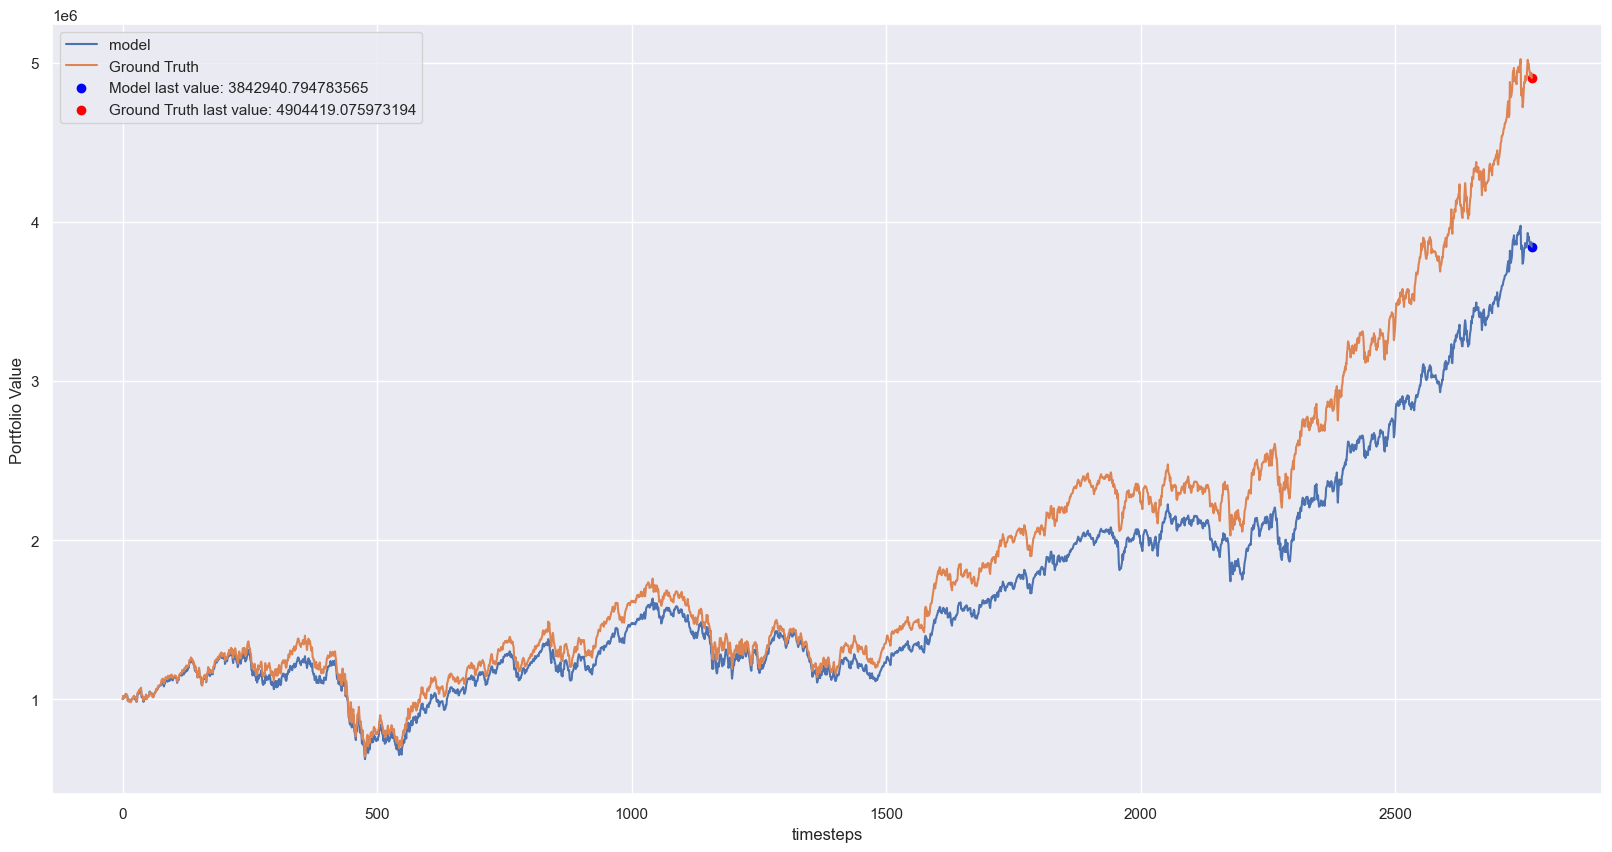

begin_total_asset:1000000
end_total_asset:3203479.4103541947
Sharpe:  1.2026111324663613


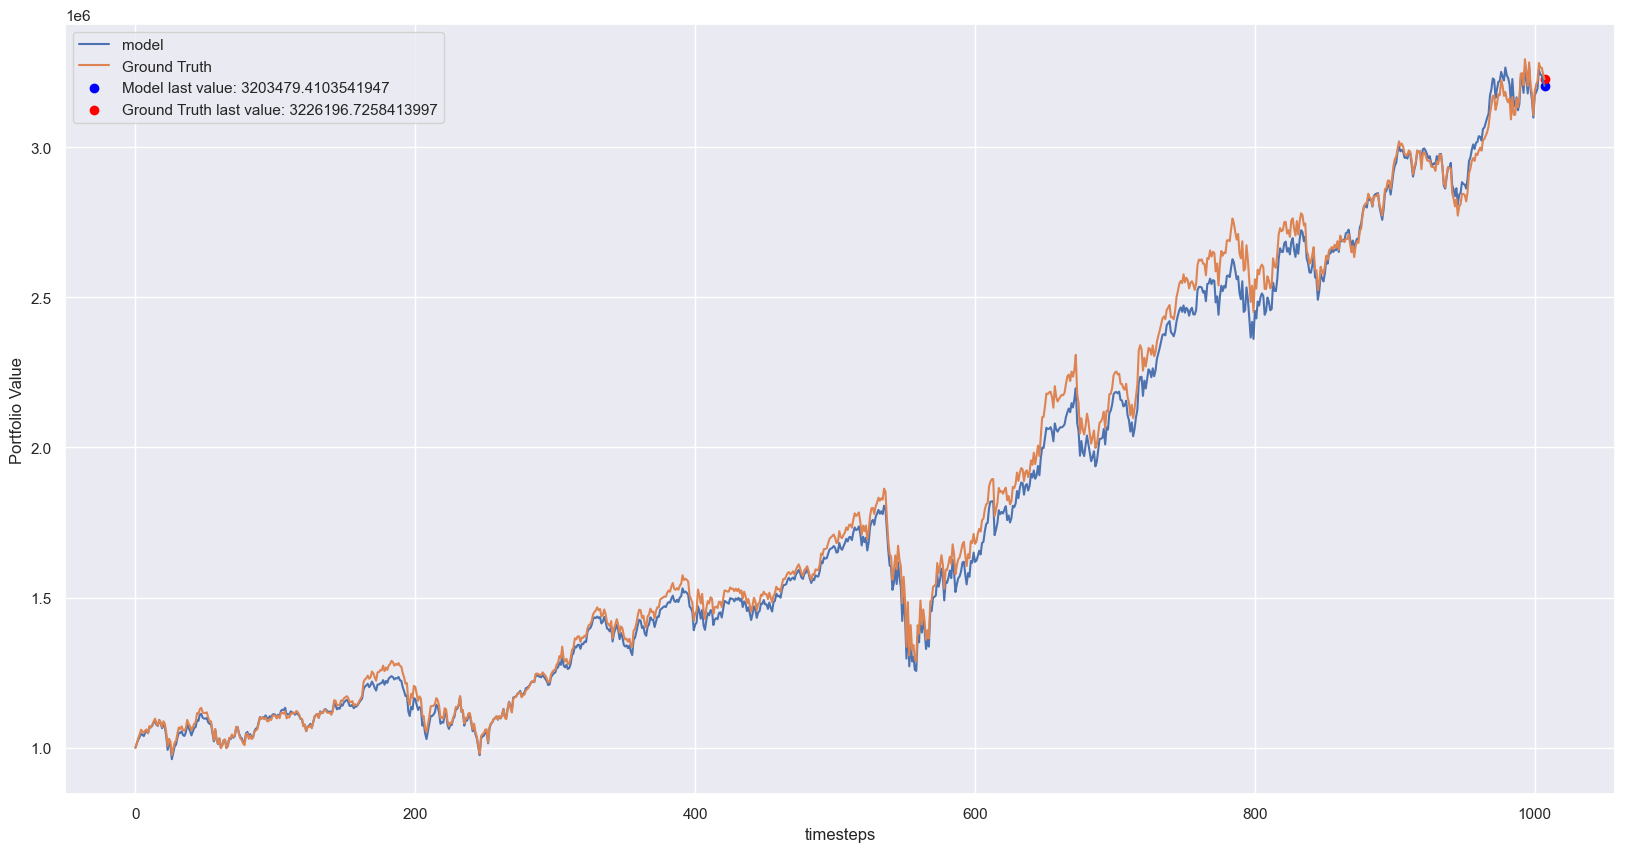

In [66]:
# train
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=reg_fit)
reg_portfolio_train = e_train_gym.asset_memory
plot_portfolio(reg_portfolio_train, true_portfolio_train)

# trade
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=reg_trade)
reg_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(reg_portfolio_trade, true_portfolio_trade)

In [67]:
ols_return(true_portfolio_train, reg_portfolio_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 8.550e+04
Date:                Fri, 24 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:02:42   Log-Likelihood:                 12156.
No. Observations:                2768   AIC:                        -2.431e+04
Df Residuals:                    2766   BIC:                        -2.430e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.63e-05    5.7e-05      1.338      0.1

In [68]:
ols_return(true_portfolio_trade, reg_portfolio_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 4.727e+04
Date:                Fri, 24 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:02:43   Log-Likelihood:                 4574.0
No. Observations:                1007   AIC:                            -9144.
Df Residuals:                    1005   BIC:                            -9134.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.647e-05   8.15e-05     -0.202      0.8

In [74]:
train_data["moribvol"].values
reg_fit.reshape(-1)

array([0.13636364, 0.06060606, 0.01515152, ..., 0.04545455, 0.12121212,
       0.16666667])

array([0.09049285, 0.09055301, 0.09049285, ..., 0.09070733, 0.09048093,
       0.09133842])

In [69]:
ols_action(train_data["moribvol"], reg_fit)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     358.3
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           1.92e-79
Time:                        14:02:46   Log-Likelihood:                 49504.
No. Observations:               30459   AIC:                        -9.900e+04
Df Residuals:                   30457   BIC:                        -9.899e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5281      0.086    -17.865      0.0

In [53]:
ols_action(trade_data["moribvol"], reg_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.463
Date:                Fri, 24 Mar 2023   Prob (F-statistic):              0.226
Time:                        05:03:26   Log-Likelihood:                 17962.
No. Observations:               11088   AIC:                        -3.592e+04
Df Residuals:                   11086   BIC:                        -3.591e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1033      0.161     -0.643      0.5

## RandomForest

In [17]:
clf = RandomForestRegressor(max_depth=2, random_state=0)
clf.fit(X, Y)

# train
clf_fit = clf.predict((X.values.reshape(-1, feature_dimension))).reshape(-1, stock_dimension)
clf_fit = softmax(clf_fit)

# trade
clf_trade = clf.predict((X_trade.values.reshape(-1, feature_dimension))).reshape(-1, stock_dimension)
clf_trade = softmax(clf_trade)

RandomForestRegressor(max_depth=2, random_state=0)

In [18]:
# train
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=clf_fit)
clf_portfolio_train = e_train_gym.asset_memory
plot_portfolio(clf_portfolio_train, true_portfolio_train)

# trade
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=clf_trade)
clf_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(clf_portfolio_trade, true_portfolio_trade)

begin_total_asset:1000000
end_total_asset:3843266.9780635866
Sharpe:  0.6109682673652438
begin_total_asset:1000000
end_total_asset:3204722.773035892
Sharpe:  1.201942049794511


In [20]:
ols_return(true_portfolio_train, clf_portfolio_train)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                          8.594e+04
Date:                Wed, 22 Mar 2023   Prob (F-statistic):                        0.00
Time:                        02:53:42   Log-Likelihood:                          12164.
No. Observations:                2769   AIC:                                 -2.433e+04
Df Residuals:                    2768   BIC:                                 -2.432e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [21]:
ols_return(true_portfolio_trade, clf_portfolio_trade)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                          4.763e+04
Date:                Wed, 22 Mar 2023   Prob (F-statistic):                        0.00
Time:                        02:53:42   Log-Likelihood:                          4579.0
No. Observations:                1008   AIC:                                     -9156.
Df Residuals:                    1007   BIC:                                     -9151.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## LSTM

In [33]:
# Set seeds
seed = 0
e_train_gym.seed(seed)
e_train_gym.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Prepare dataset
X = X.astype(np.float32) 
Y = Y.astype(np.float32) 
X_trade = X_trade.astype(np.float32) 
Y_trade = Y_trade.astype(np.float32)

train_dataset = Dataset(X.values.reshape(-1, stock_dimension*feature_dimension), Y.values.reshape(-1, stock_dimension))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
trade_dataset = Dataset(X_trade.values.reshape(-1, stock_dimension*feature_dimension), Y_trade.values.reshape(-1, stock_dimension))

[0]

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return F.softmax(out)

In [37]:
lstm = LSTMModel(input_size=stock_dimension*feature_dimension, 
                 hidden_size=128, 
                 num_layers=1, 
                 output_size=stock_dimension)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=3e-4)
num_epochs = 10000

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = lstm(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

begin_total_asset:1000000
end_total_asset:4383811.971778089
Sharpe:  0.6357627019407474


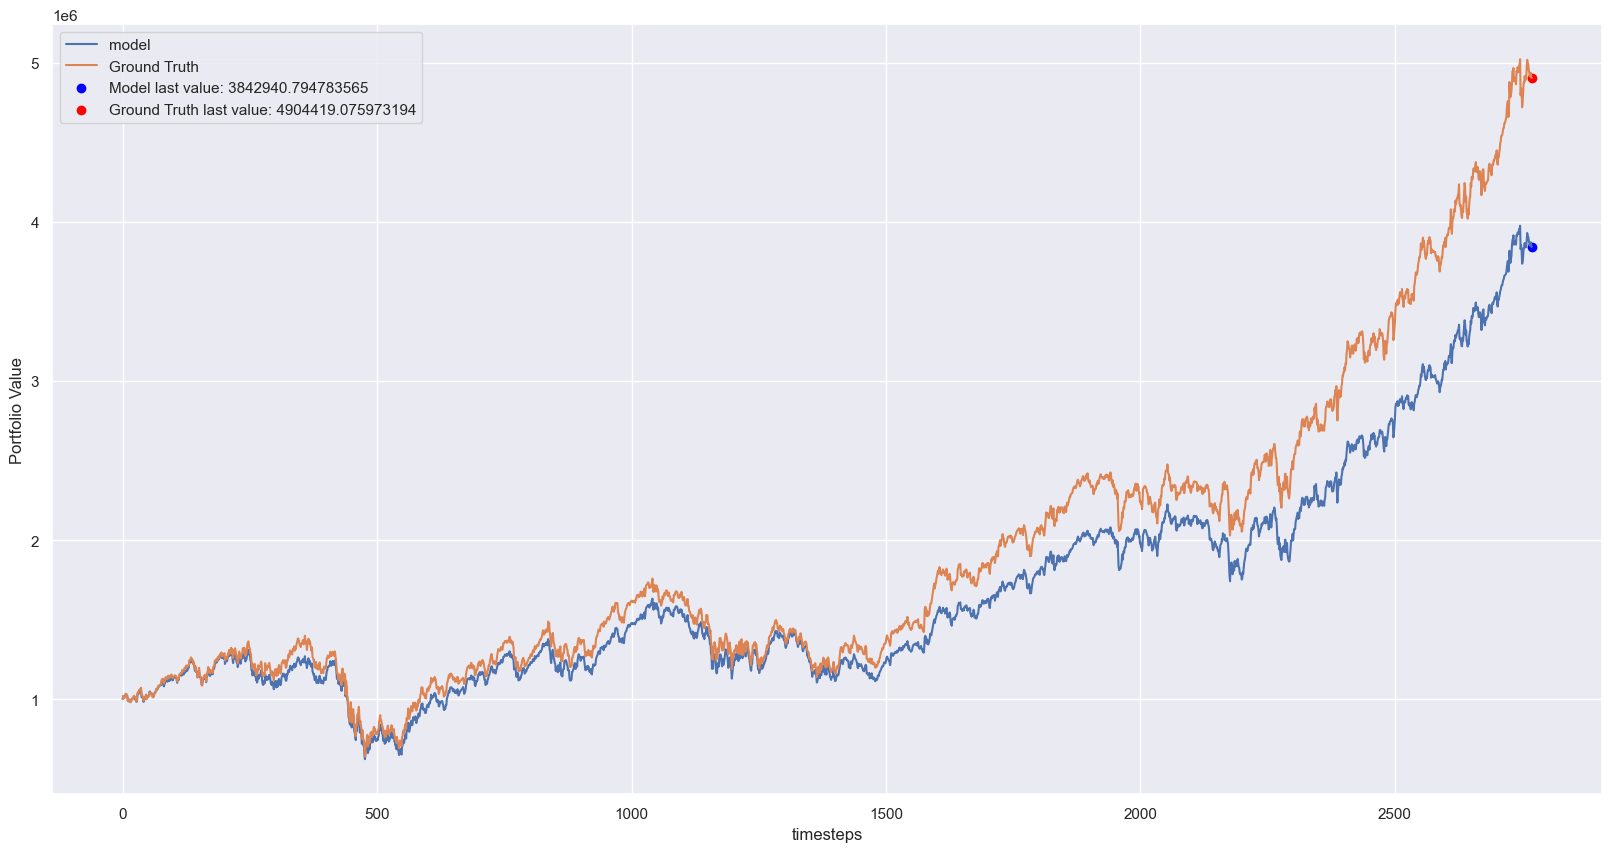

begin_total_asset:1000000
end_total_asset:3611699.4460426257
Sharpe:  1.2399228415512271


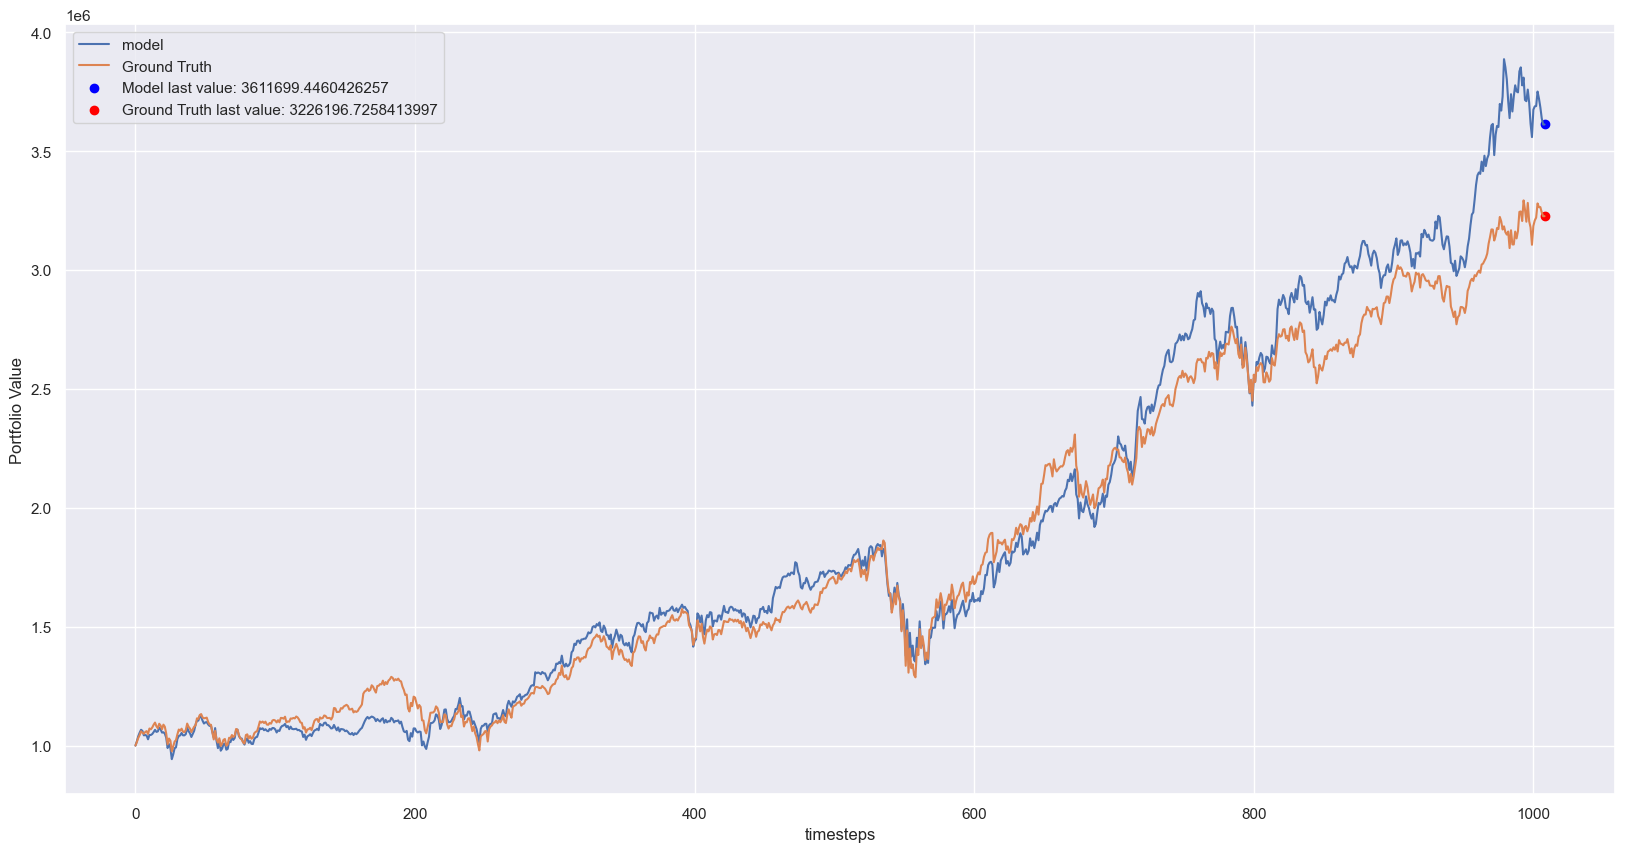

In [45]:
# train
lstm_fit = lstm(train_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=lstm_fit)
lstm_portfolio_train = e_train_gym.asset_memory
plot_portfolio(reg_portfolio_train, true_portfolio_train)

# trade
lstm_trade = lstm(trade_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=lstm_trade)
lstm_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(lstm_portfolio_trade, true_portfolio_trade)

In [46]:
ols_return(true_portfolio_train, lstm_portfolio_train)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          7.491e+05
Date:                Wed, 22 Mar 2023   Prob (F-statistic):                        0.00
Time:                        12:28:20   Log-Likelihood:                          15123.
No. Observations:                2769   AIC:                                 -3.024e+04
Df Residuals:                    2768   BIC:                                 -3.024e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [47]:
ols_return(true_portfolio_trade, lstm_portfolio_trade)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.843
Model:                            OLS   Adj. R-squared (uncentered):              0.843
Method:                 Least Squares   F-statistic:                              5397.
Date:                Wed, 22 Mar 2023   Prob (F-statistic):                        0.00
Time:                        12:28:28   Log-Likelihood:                          3557.2
No. Observations:                1008   AIC:                                     -7112.
Df Residuals:                    1007   BIC:                                     -7108.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Neural Net

In [34]:
class NeuralNet(nn.Module):
	def __init__(self, state_dim, action_dim, max_action):
		super(NeuralNet, self).__init__()
		self.l1 = nn.Linear(state_dim, 128)
		self.l2 = nn.Linear(128, 128)
		self.l3 = nn.Linear(128, action_dim)
		self.max_action = max_action

	def forward(self, state):
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		return self.max_action * F.softmax(self.l3(a))

In [52]:
ann = NeuralNet(state_dim=stock_dimension*feature_dimension, 
                action_dim=stock_dimension, 
                max_action=float(e_train_gym.action_space.high[0]))

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(ann.parameters(), lr=3e-4)
num_epochs = 10000

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = ann(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

begin_total_asset:1000000
end_total_asset:4456810.054581757
Sharpe:  0.6418920577477047


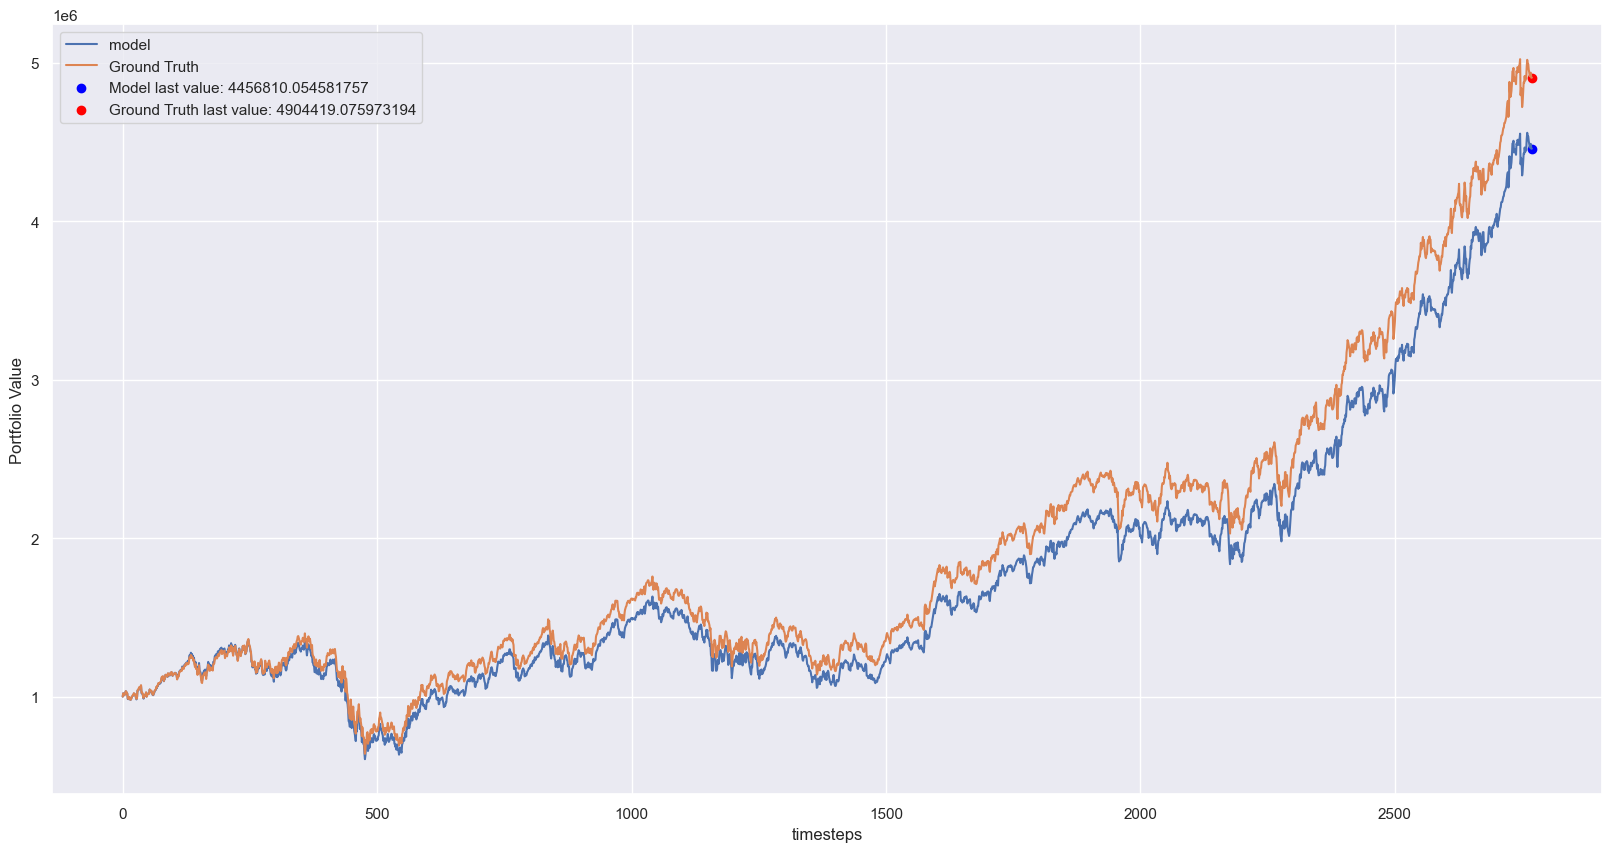

begin_total_asset:1000000
end_total_asset:4140508.4049074003
Sharpe:  1.3268842502596172


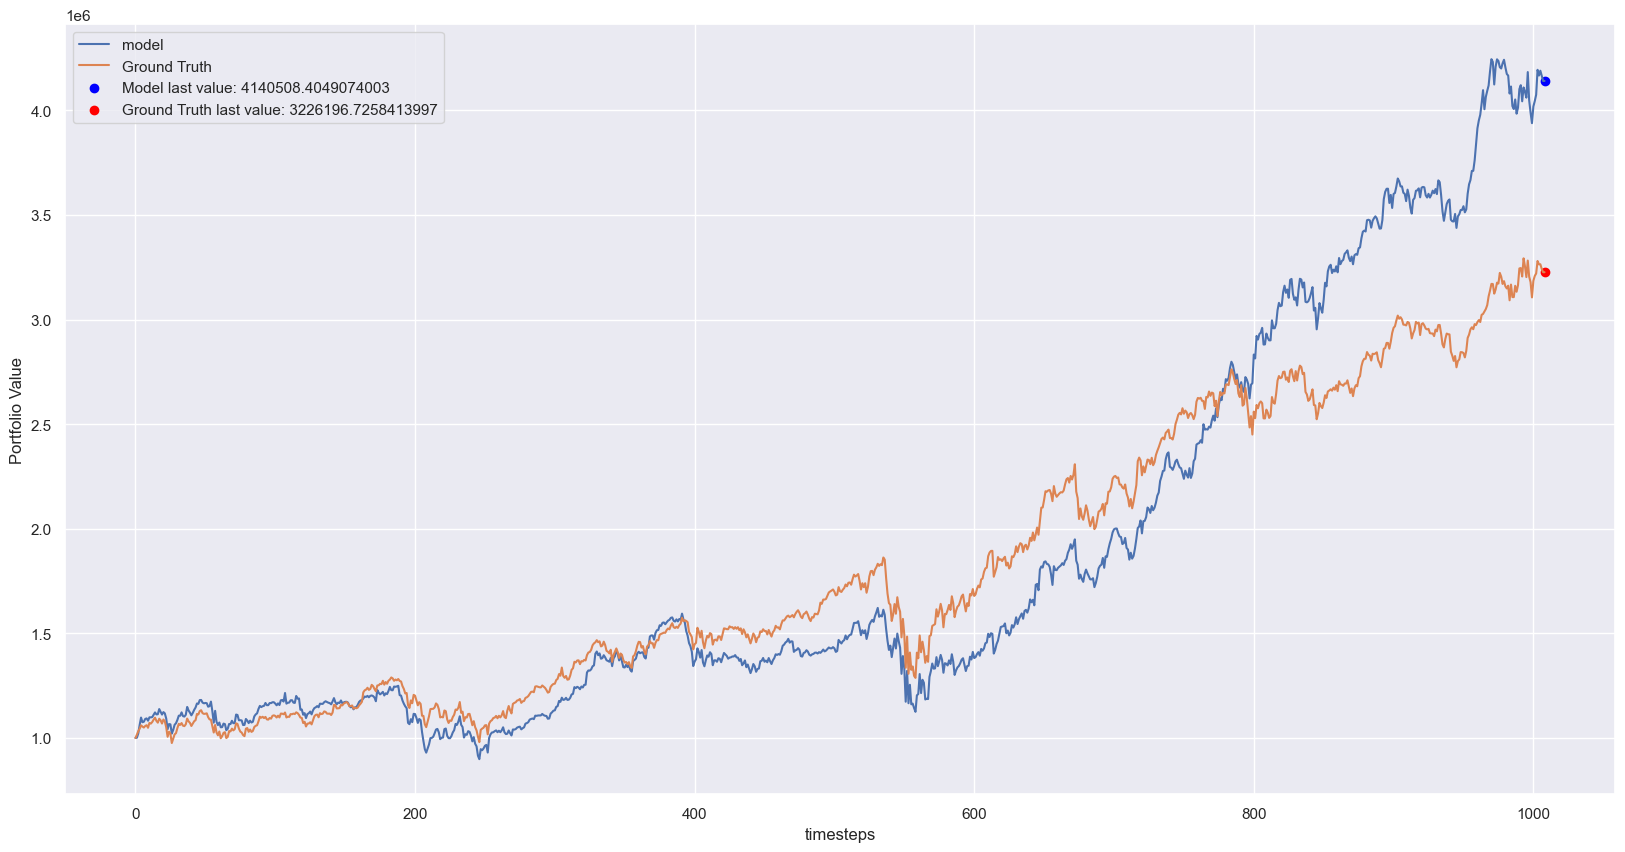

In [53]:
# train
ann_fit = ann(train_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=ann_fit)
ann_portfolio_train = e_train_gym.asset_memory
plot_portfolio(ann_portfolio_train, true_portfolio_train)

# trade 
ann_trade = ann(trade_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=ann_trade)
ann_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(ann_portfolio_trade, true_portfolio_trade)

In [54]:
ols_return(true_portfolio_train, ann_portfolio_train)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          8.619e+05
Date:                Wed, 22 Mar 2023   Prob (F-statistic):                        0.00
Time:                        13:11:50   Log-Likelihood:                          15316.
No. Observations:                2769   AIC:                                 -3.063e+04
Df Residuals:                    2768   BIC:                                 -3.062e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [55]:
ols_return(true_portfolio_trade, ann_portfolio_trade)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.811
Model:                            OLS   Adj. R-squared (uncentered):              0.811
Method:                 Least Squares   F-statistic:                              4331.
Date:                Wed, 22 Mar 2023   Prob (F-statistic):                        0.00
Time:                        13:11:52   Log-Likelihood:                          3465.4
No. Observations:                1008   AIC:                                     -6929.
Df Residuals:                    1007   BIC:                                     -6924.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Placebo Test

In [76]:
X_fake_train = X_fake_train.astype(np.float32) 
X_fake_trade = X_fake_trade.astype(np.float32) 

fake_train_dataset = Dataset(X_fake_train.values.reshape(-1, stock_dimension*feature_dimension), Y.values.reshape(-1, stock_dimension))
fake_train_dataloader = torch.utils.data.DataLoader(fake_train_dataset, batch_size=256, shuffle=True)
fake_trade_dataset = Dataset(X_fake_trade.values.reshape(-1, stock_dimension*feature_dimension), Y_trade.values.reshape(-1, stock_dimension))

In [77]:
ann = NeuralNet(state_dim=stock_dimension*feature_dimension, 
                action_dim=stock_dimension, 
                max_action=float(e_train_gym.action_space.high[0]))

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(ann.parameters(), lr=3e-4)
num_epochs = 10000

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = ann(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

begin_total_asset:1000000
end_total_asset:2138077.827450467
Sharpe:  0.3827609635893908


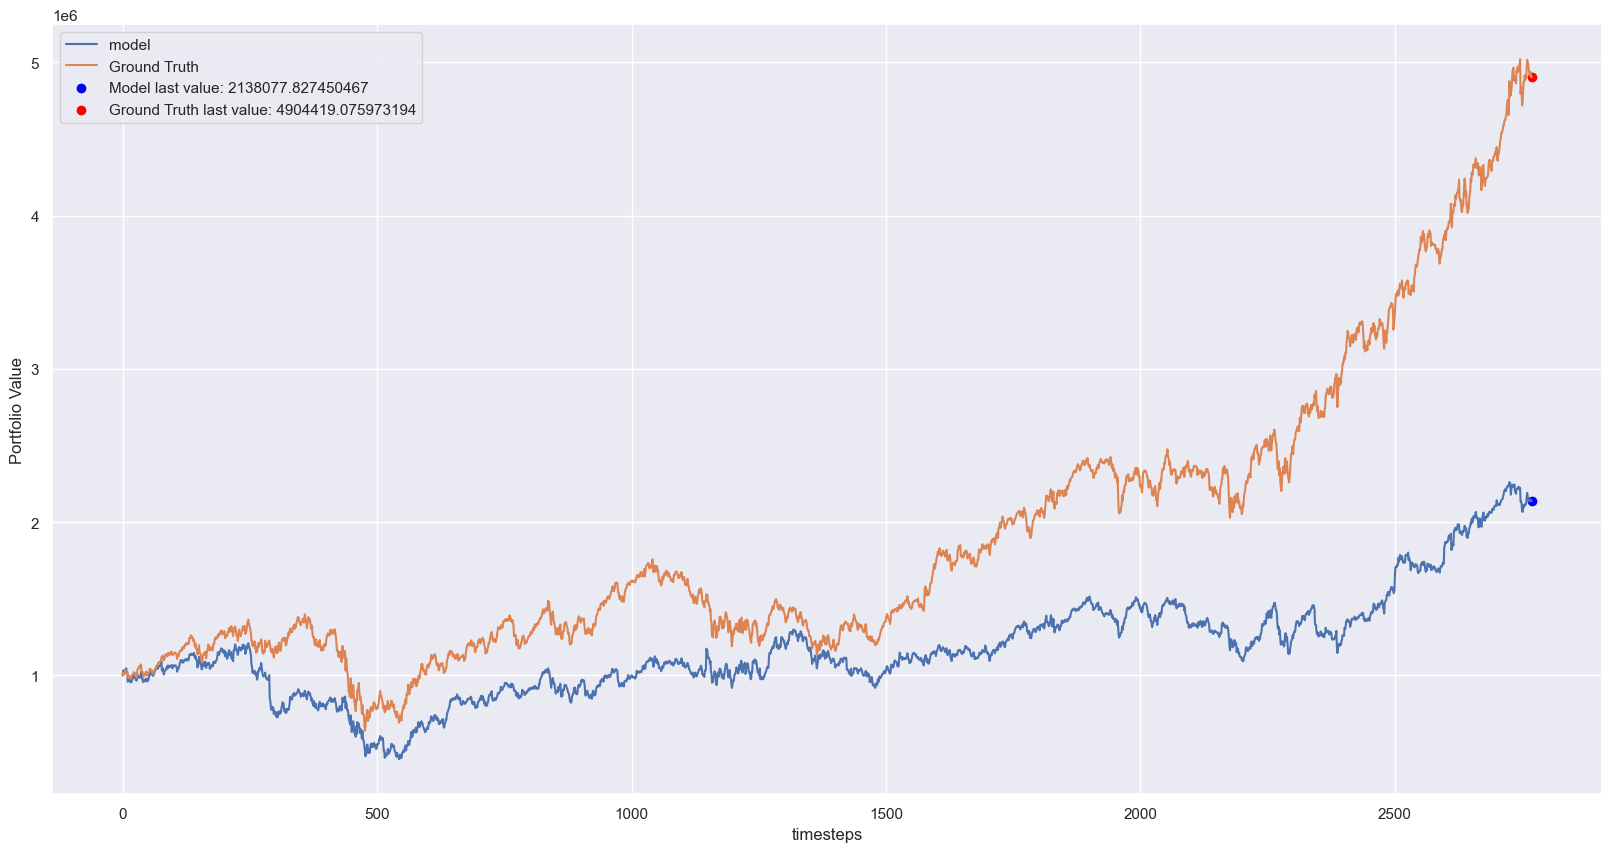

begin_total_asset:1000000
end_total_asset:3177899.037141011
Sharpe:  1.0253711062891568


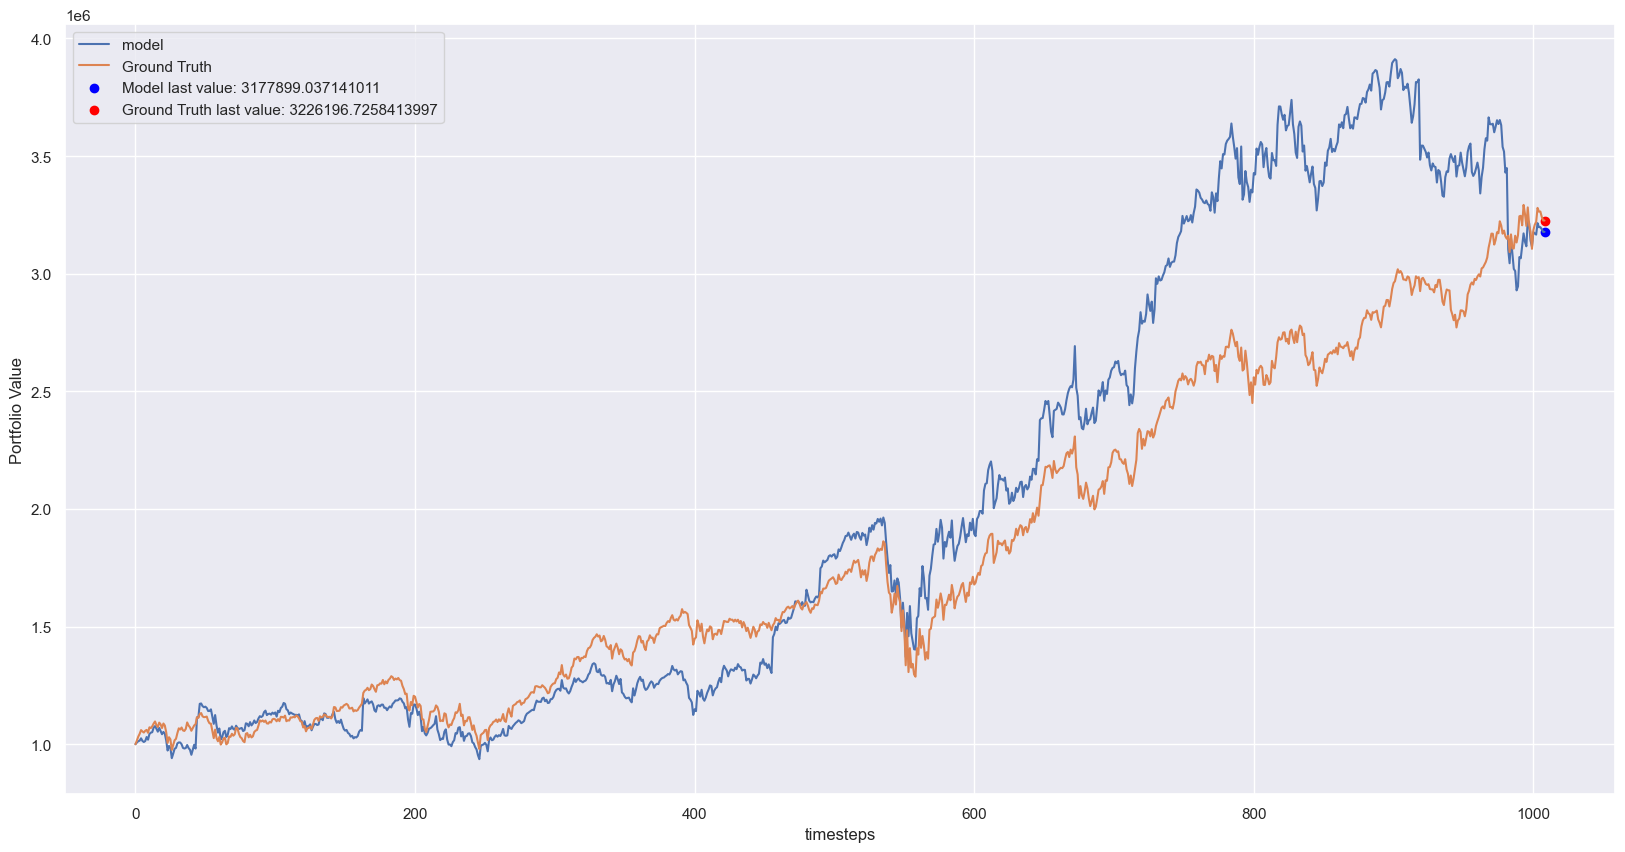

In [78]:
# train
fake_ann_fit = ann(fake_train_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=fake_ann_fit)
fake_ann_portfolio_train = e_train_gym.asset_memory
plot_portfolio(fake_ann_portfolio_train, true_portfolio_train)

# trade 
fake_ann_trade = ann(fake_trade_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=fake_ann_trade)
fake_ann_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(fake_ann_portfolio_trade, true_portfolio_trade)

In [79]:
ols_return(true_portfolio_train, fake_ann_portfolio_train)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.657
Model:                            OLS   Adj. R-squared (uncentered):              0.657
Method:                 Least Squares   F-statistic:                              5298.
Date:                Wed, 22 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:47:38   Log-Likelihood:                          8844.2
No. Observations:                2769   AIC:                                 -1.769e+04
Df Residuals:                    2768   BIC:                                 -1.768e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [80]:
ols_return(true_portfolio_trade, fake_ann_portfolio_trade)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.652
Model:                            OLS   Adj. R-squared (uncentered):              0.651
Method:                 Least Squares   F-statistic:                              1884.
Date:                Wed, 22 Mar 2023   Prob (F-statistic):                   7.12e-233
Time:                        15:47:38   Log-Likelihood:                          3156.4
No. Observations:                1008   AIC:                                     -6311.
Df Residuals:                    1007   BIC:                                     -6306.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------